In [1]:
import re
import numpy as np
import pandas as pd

In [2]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
#spacy for lemmatization
import spacy

In [4]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Remove deprecationWarning that I can't fix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# NLTK for removing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tagum', 'city', 'davao','ordinance', 'thereof', 'section'])

In [7]:
# Import CSV Ordinance Dataset
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


In [8]:
# List all ordinance titles
# Convert to list
data = list(df.OT) 
print(data[:1])

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


In [9]:
# Remove qoutes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]

# Remove words ending with ING like amending, regulating
# Implemtation to be improved / Seems to improve topics
data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]


pprint(data[:5])

['“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES '
 'ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.',
 '“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) '
 'ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE '
 'UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, '
 'REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE '
 'PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”.',
 '“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FOR INDIGENT TAGUMENYOS, ITS '
 'MANAGEMENT, PROCEDURES AND GUIDELINES AND FUNDS THEREFOR”.',
 'AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 AND SECTION 3 OF CITY ORDINANCE '
 'NO. 820, S-2017 “AN ORDINANCE INTO A LOAN AGREEMENT WITH THE DEVELOPMENT '
 'BANK OF THE PHILIPPINES, IN THE AMOUNT OF SIX HUNDRED EIGHTY MILLION PESOS '
 '(P 680,000,000.00) TO FUND THE ACQUISITION OF HEAVY EQUIPMENT,ACQUISITION OF '
 'SERVICE VEHICLES, ACQUISITION O

In [10]:
#preprocess using gensim simple_preprocess and tokenize into words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:5])

[['an',
  'ordinance',
  'the',
  'practice',
  'of',
  'traditional',
  'home',
  'birth',
  'delivery',
  'or',
  'deliveries',
  'attended',
  'by',
  'traditional',
  'birth',
  'attendant',
  'or',
  'mananabang'],
 ['an',
  'ordinance',
  'the',
  'members',
  'of',
  'the',
  'city',
  'tricycle',
  'and',
  'regulatory',
  'board',
  'ctfrb',
  'its',
  'functions',
  'and',
  'procedures',
  'and',
  'motorized',
  'tricycle',
  'for',
  'hire',
  'mth',
  'tricycle',
  'utility',
  'vehicle',
  'tuv',
  'and',
  'tricycle',
  'utility',
  'for',
  'hire',
  'tuh',
  'guidelines',
  'regulations',
  'and',
  'operations',
  'the',
  'collection',
  'of',
  'fees',
  'charges',
  'administrative',
  'provisions',
  'and',
  'penalties',
  'for',
  'violation',
  'thereof'],
 ['an',
  'ordinance',
  'funeral',
  'and',
  'burial',
  'assistance',
  'for',
  'indigent',
  'tagumenyos',
  'its',
  'management',
  'procedures',
  'and',
  'guidelines',
  'and',
  'funds',
  'theref

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

['an',
 'ordinance',
 'the',
 'practice',
 'of',
 'traditional',
 'home',
 'birth',
 'delivery',
 'or',
 'deliveries',
 'attended',
 'by',
 'traditional',
 'birth',
 'attendant',
 'or',
 'mananabang']


In [34]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Code snippets from Selva Prabhakaran | Topic Modeling with Gensim (Python)
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def stemmer(texts):
    new_list = []
    temp = []
    for lists in texts:
        new_list.append(temp)
        for word in lists:
            temp.append(ps.stem(word))
        temp = []
    return new_list

In [43]:
# Remove Stop Words and Form Bigrams
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# If stemming
data_stemmed = stemmer(data_words_bigrams)

# Lematize keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

pprint(data_lemmatized[:1])

[['practice',
  'traditional',
  'home',
  'birth',
  'delivery',
  'delivery',
  'attend',
  'traditional',
  'birth',
  'attendant',
  'mananabang']]


In [36]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 1), (4, 1), (5, 1), (6, 2)]]


In [37]:
id2word[0]

'attend'

In [38]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attend', 2),
  ('birth', 2),
  ('deliveri', 2),
  ('home', 1),
  ('mananabang', 1),
  ('practic', 1),
  ('tradit', 2)]]

In [39]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.136*"municip" + 0.044*"offic" + 0.023*"mayor" + 0.021*"fund" + 0.021*"posit" + 0.020*"purpos" + 0.017*"tax" + 0.015*"servic" + 0.014*"duti" + 0.014*"school"'), (1, '0.035*"oper" + 0.024*"vehicl" + 0.023*"barangay" + 0.022*"guidelin" + 0.020*"thousand" + 0.018*"fund" + 0.018*"fee" + 0.018*"peso" + 0.015*"util" + 0.015*"regul"'), (2, '0.039*"street" + 0.035*"public" + 0.030*"market" + 0.028*"penalti" + 0.028*"road" + 0.026*"within" + 0.025*"violat" + 0.011*"traffic" + 0.011*"along" + 0.010*"bonifacio"'), (3, '0.041*"penalti" + 0.035*"violat" + 0.019*"use" + 0.017*"fee" + 0.016*"public" + 0.015*"purpos" + 0.013*"provid" + 0.013*"establish" + 0.013*"busi" + 0.012*"seri"'), (4, '0.037*"barangay" + 0.033*"area" + 0.028*"lot" + 0.027*"portion" + 0.019*"zone" + 0.015*"industri" + 0.015*"tct" + 0.015*"square_met" + 0.014*"park" + 0.014*"locat"')]


In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.744311832990833

Coherence Score:  0.3871297340107368


In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.292225 -0.066224       1        1  27.873662
1      0.020051 -0.067610       2        1  22.798620
2     -0.181074 -0.064905       3        1  17.334698
3     -0.123736 -0.089783       4        1  17.277843
4     -0.007466  0.288523       5        1  14.715177, topic_info=              Term        Freq       Total Category  logprob  loglift
376        municip  297.000000  297.000000  Default  30.0000  30.0000
208          offic   97.000000   97.000000  Default  29.0000  29.0000
86          street   54.000000   54.000000  Default  28.0000  28.0000
90        barangay   85.000000   85.000000  Default  27.0000  27.0000
19         penalti  110.000000  110.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
68        del_nort   10.909821   12.574596   Topic5  -4.6638   1.7743
349            own   10.953363   12.931155   Topic5  -4.6599   1.7503
346          locat   15.754316   21.762510   Topic5  -4.2964   1.5932
90        barangay   42.579958   85.643784   Topic5  -3.3021   1.2175
41   continue_read    9.096937   20.683472   Topic5  -4.8456   1.0949

[236 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
163       4  0.898279         act
7         2  0.976091   administr
150       5  0.958645  agricultur
152       3  0.929047       along
313       2  0.916066       amend
...     ...       ...         ...
138       2  0.233245      within
138       3  0.763346      within
115       1  0.644551        year
115       4  0.368315        year
162       5  0.938182        zone

[242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [22]:
# Build Mallet LDA Model
mallet_path = '/Users/root1/Documents/lda/mallet/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=15, id2word=id2word)

In [23]:
# Show Topics
# Only few topics make sense for me
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('purpose', 0.25412541254125415),
   ('composition', 0.0462046204620462),
   ('commercial', 0.033003300330033),
   ('power', 0.026402640264026403),
   ('municipality', 0.0231023102310231),
   ('food', 0.0231023102310231),
   ('installation', 0.0231023102310231),
   ('cable', 0.0231023102310231),
   ('organization', 0.0231023102310231),
   ('authorize', 0.019801980198019802)]),
 (1,
  [('fund', 0.22756410256410256),
   ('guideline', 0.15705128205128205),
   ('implementation', 0.08012820512820513),
   ('program', 0.07692307692307693),
   ('policy', 0.07051282051282051),
   ('educational', 0.035256410256410256),
   ('scholarship', 0.02564102564102564),
   ('education', 0.019230769230769232),
   ('poor', 0.019230769230769232),
   ('otherwise_known', 0.01282051282051282)]),
 (5,
  [('fee', 0.1566265060240964),
   ('operation', 0.14457831325301204),
   ('rate', 0.06626506024096386),
   ('development', 0.05120481927710843),
   ('procedure', 0.04216867469879518),
   ('sale', 0.0391566

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

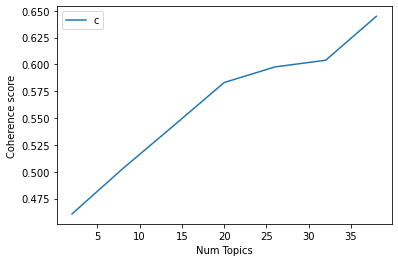

In [26]:
# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores with increasing number of topics

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4607
Num Topics = 8  has Coherence Value of 0.5029
Num Topics = 14  has Coherence Value of 0.5428
Num Topics = 20  has Coherence Value of 0.5832
Num Topics = 26  has Coherence Value of 0.5977
Num Topics = 32  has Coherence Value of 0.6039
Num Topics = 38  has Coherence Value of 0.6449


In [28]:
# Select the model and print the topics
optimal_model = model_list[2] # when number of topics is 8
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.098*"area" + 0.049*"portion" + 0.041*"situate" + 0.041*"continue_reade" + '
  '0.038*"purpose" + 0.038*"cover" + 0.035*"locate" + 0.030*"residential" + '
  '0.030*"square_meter" + 0.030*"continue_reading"'),
 (1,
  '0.113*"amount" + 0.100*"office" + 0.074*"school" + 0.042*"student" + '
  '0.032*"mayor" + 0.026*"site" + 0.023*"food" + 0.023*"honorable" + '
  '0.019*"equipment" + 0.016*"elementary"'),
 (2,
  '0.079*"code" + 0.063*"government" + 0.056*"provide" + 0.050*"tax" + '
  '0.043*"property" + 0.036*"real" + 0.033*"republic_act" + 0.026*"schedule" + '
  '0.026*"chapter" + 0.026*"condition"'),
 (3,
  '0.323*"municipal" + 0.111*"market" + 0.043*"permit" + 0.034*"appropriation" '
  '+ 0.031*"mayor" + 0.025*"employee" + 0.025*"annual" + 0.018*"part" + '
  '0.015*"secure" + 0.015*"honor"'),
 (4,
  '0.307*"penalty" + 0.262*"violation" + 0.030*"traffic" + 0.028*"place" + '
  '0.028*"clock" + 0.022*"term" + 0.022*"close" + 0.017*"hour" + '
  '0.017*"poblacion" + 0.008*"orderly"')

In [29]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1077,"medical, revise, benefit, assistance, official...",“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME...
1,1,6.0,0.1860,"operation, regulation, rule, function, provisi...",“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE...
2,2,6.0,0.1013,"operation, regulation, rule, function, provisi...",“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FO...
3,3,1.0,0.1459,"amount, office, school, student, mayor, site, ...","AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 A..."
4,4,5.0,0.0853,"fee, rate, development, sale, house, document,...","“AN ORDINANCE THE CITY HISTORICAL, CULTURAL AN..."
5,5,7.0,0.0879,"guideline, establishment, implementation, prog...",“AN ORDINANCE THE HUGPONG SERBISYO PARA SA TAG...
6,6,0.0,0.0879,"area, portion, situate, continue_reade, purpos...",“AN ORDINANCE THE AREA IN FRONT OF THE HISTORI...
7,7,0.0,0.0879,"area, portion, situate, continue_reade, purpos...",AN ORDINANCE SECTION 2 OF CITY ORDINANCE NO. 2...
8,8,10.0,0.0944,"fund, year, peso, monthly, system, allowance, ...",AN ORDINANCE THE TEMPORARY CLOSURE OF PORTIONS...
9,9,12.0,0.2024,"municipality, street, territorial_jurisdiction...",“AN ORDINANCE TEMPORARY CLOSURE FROM CORNER R...


In [30]:
# Convert malletmodel to to gensim lda model for pyLDAvis
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12    -0.028554 -0.134083       1        1  7.026554
3      0.028548 -0.067383       2        1  6.807857
10     0.251513  0.222370       3        1  6.805110
5      0.030859 -0.002986       4        1  6.716481
9      0.084110 -0.062740       5        1  6.712435
14    -0.245713  0.186521       6        1  6.693876
6     -0.018447 -0.117488       7        1  6.665794
4     -0.286838  0.200597       8        1  6.663150
7     -0.069937 -0.206472       9        1  6.654757
11    -0.013843 -0.171298      10        1  6.641015
2      0.097978 -0.058837      11        1  6.629463
13    -0.129005  0.106149      12        1  6.568089
8      0.025655 -0.051038      13        1  6.529055
1      0.261668  0.203527      14        1  6.453581
0      0.012007 -0.046840      15        1  6.432783, topic_info=            Term        Freq       Total Category  logprob  loglift
16       penalty  105.000000  105.000000  Default  30.0000  30.0000
22     violation   91.000000   91.000000  Default  29.0000  29.0000
23          fund  108.000000  108.000000  Default  28.0000  28.0000
261    municipal  116.000000  116.000000  Default  27.0000  27.0000
74       purpose   87.000000   87.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
339         high    3.389229    4.338291  Topic15  -4.5397   2.4969
502  functionary    3.389229    4.397254  Topic15  -4.5397   2.4834
501    financial    3.389229    6.634122  Topic15  -4.5397   2.0721
181     barangay    3.389229   11.993284  Topic15  -4.5397   1.4800
282          tax    3.389229   19.296756  Topic15  -4.5397   1.0044

[867 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1068      4  1.001634       abbatoir
196       5  0.953937         access
500      10  0.924530       accident
1109     13  0.952798    accommodate
284       4  1.001634  accreditation
...     ...       ...            ...
76       14  0.155037         worker
624      12  0.870007      workplace
53        9  0.044127           year
53       11  0.970802           year
78       13  0.952798           zone

[926 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 11, 6, 10, 15, 7, 5, 8, 12, 3, 14, 9, 2, 1])